Subtask B: Verifiable factual claims detection: Given a tweet, predict whether it contains a verifiable factual claim. This is a binary task with two labels: Yes and No. This is a classification task

check this: 
- https://github.com/avirup88/Binary-Classification-using-N-Gram-Model-on-Text-Data
- https://stackoverflow.com/questions/48003907/how-to-train-naive-bayes-classifier-for-n-gram-movie-reviews

In [247]:
import pandas as pd
import re
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier

from sklearn.naive_bayes import ComplementNB #0.4972557628979144
from sklearn.naive_bayes import MultinomialNB #0.5016465422612514
from sklearn.naive_bayes import BernoulliNB #0.5082327113062569
from sklearn.naive_bayes import GaussianNB #0.47530186608122943
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import nltk
from nltk.stem import WordNetLemmatizer 
import spacy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Preprocess

In [248]:
stop_words = set(stopwords.words("english"))

In [249]:
df = pd.read_csv("data/1b/CT22_english_1B_claim_train.tsv", sep='\t')

In [250]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3324 entries, 0 to 3323
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   topic        3324 non-null   object 
 1   tweet_id     3324 non-null   float64
 2   tweet_url    3324 non-null   object 
 3   tweet_text   3324 non-null   object 
 4   class_label  3324 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 130.0+ KB


In [251]:
df.isnull().sum()

topic          0
tweet_id       0
tweet_url      0
tweet_text     0
class_label    0
dtype: int64

In [252]:
df["class_label"].value_counts()

1    2122
0    1202
Name: class_label, dtype: int64

In [253]:
true_df = df.loc[df['class_label'] == 1]
true_df_1000 = true_df[:1000]

In [254]:
false_df = df.loc[df['class_label'] == 0]
false_df_1000 = true_df[:1000]

In [255]:
frames = [true_df_1000, false_df_1000]
df_v2 = pd.concat(frames)

In [256]:
class_label = df["class_label"].values
#class_label = df_v2["class_label"].values
class_label.shape

(3324,)

In [257]:
tweet_txt = df["tweet_text"].values
#tweet_txt = df_v2["tweet_text"].values
tweet_txt.shape

(3324,)

In [258]:
df1 = pd.DataFrame(tweet_txt)
df1 = df1.rename(columns={0:'tweet'})

In [259]:
df2 = pd.DataFrame(class_label)
df2 = df2.rename(columns={0:'label'})
new_df = pd.concat([df1, df2], axis=1)

In [260]:
new_df.head()

,tweet,label
0,"India's gift of 100,000 COVID-19 vaccines arri...",1
1,Here’s what I’m doing while I wait my turn for...,0
2,"This afternoon, I’m hosting an event with the ...",0
3,"Help shops like mine stay open. Mask up, avoid...",0
4,As part of the ongoing nationwide vaccination ...,1


## Preprocessing

In [261]:
def preprocess(article):
    doc_list = []
    for art in article:
        art = re.sub('[^A-Za-z0-9]+', ' ', art.lower())
        content_tokens = word_tokenize(art)
        doc = [word for word in  content_tokens if not word.lower() in stop_words]
        doc = [n for n in doc if not n.isdigit()]
        doc_list.append(" ".join(doc))
        
    return doc_list


In [262]:
new_df['tweet'] = preprocess(new_df['tweet'])

In [263]:
new_df.head()

,tweet,label
0,india gift covid vaccines arrived barbados ear...,1
1,wait turn covid vaccines masking staying least...,0
2,afternoon hosting event ceos johnson amp johns...,0
3,help shops like mine stay open mask avoid crow...,0
4,part ongoing nationwide vaccination rollout se...,1


## Ngrams

In [264]:
eng_words = pd.read_csv("words.txt", sep=" ")

In [265]:
blacklisted = ["http", "https", "co", "twitter", "com", "t"]

In [266]:
def getNgrams(words, n = 2):
    wordList = []
    for i in words.split():
        if i in eng_words.values:
            wordList.append(i)
    ngram_vocab = ngrams(wordList, n)
    my_dict = dict([(ng, True) for ng in ngram_vocab])  
    return my_dict  
  
    
# def getNgrams(words, n = 2):
#     ngram_vocab = ngrams(words.split(), n)
#     my_dict = dict([(ng, True) for ng in ngram_vocab])  
#     return my_dict  
  
  
# def getNgrams(words, n = 2):
#     wordList = []
#     for i in words.split():
#         if i not in blacklisted:
#             wordList.append(i)
#     ngram_vocab = ngrams(wordList, n)
#     my_dict = dict([(ng, True) for ng in ngram_vocab])  
#     return my_dict  

## Naive bayes classifier

In [267]:
resultDict = {}

for n in [1,2,3,4,5]:
    trueList = []
    falseList = []
    for line in new_df[new_df.label == 1].tweet:
        trueList.append((getNgrams(line, n), 'true'))
    for line in new_df[new_df.label == 0].tweet:
        falseList.append((getNgrams(line, n), 'false'))
    
    trainset = trueList + falseList
        
    classifier = NaiveBayesClassifier.train(trainset)
    
    resultDict[n] = classifier

In [268]:
new_df

,tweet,label
0,india gift covid vaccines arrived barbados ear...,1
1,wait turn covid vaccines masking staying least...,0
2,afternoon hosting event ceos johnson amp johns...,0
3,help shops like mine stay open mask avoid crow...,0
4,part ongoing nationwide vaccination rollout se...,1
...,...,...
3319,pearl wisdom fuckeer bill gates intentionally ...,1
3320,top infectious disease expert dr anthony fauci...,1
3321,everyone looking bill gates coronavirus vaccin...,1
3322,president first instinct response possible pan...,1


## Preprocess of test data

In [269]:
test_df = pd.read_csv("data/1b/CT22_english_1B_claim_dev_test.tsv", sep='\t')

In [270]:
test_df

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1368273275181207552,http://twitter.com/user/status/136827327518120...,"The Senate just passed COVID relief. ✔️ $1,4...",1
1,COVID-19,1368830691300020225,http://twitter.com/user/status/136883069130002...,All seven COVID-19 vaccines that have complete...,1
2,COVID-19,1367771405647933444,http://twitter.com/user/status/136777140564793...,In India the vaccination program is progressin...,1
3,COVID-19,1354211785293746177,http://twitter.com/user/status/135421178529374...,Vaccines are here. But it's important that we ...,1
4,COVID-19,1359553863590678533,http://twitter.com/user/status/135955386359067...,BREAKING @ians_india: Canadian Prime Minister ...,0
...,...,...,...,...,...
906,COVID-19,1284918427228893184,http://twitter.com/user/status/128491842722889...,Moderna’s experimental coronavirus vaccine mov...,1
907,COVID-19,1286604745818349568,http://twitter.com/user/status/128660474581834...,Morning - I drink gaumutra Lunch- I have Patan...,0
908,COVID-19,1297055497984421888,http://twitter.com/user/status/129705549798442...,Somehow I feel that this high level academic d...,0
909,COVID-19,1236601634454528000,http://twitter.com/user/status/123660163445452...,"Not just Manila, pero pwede bang buong ncr l, ...",0


In [271]:
class_label_test = test_df["class_label"].values
tweet_txt_test = test_df["tweet_text"].values


In [272]:
df1_test = pd.DataFrame(tweet_txt_test)
df1_test = df1_test.rename(columns={0:'tweet'})

In [273]:
df2_test = pd.DataFrame(class_label_test)
df2_test = df2_test.rename(columns={0:'label'})
new_test_df = pd.concat([df1_test, df2_test], axis=1)
new_test_df.head()

,tweet,label
0,"The Senate just passed COVID relief. ✔️ $1,4...",1
1,All seven COVID-19 vaccines that have complete...,1
2,In India the vaccination program is progressin...,1
3,Vaccines are here. But it's important that we ...,1
4,BREAKING @ians_india: Canadian Prime Minister ...,0


In [274]:
new_test_df['tweet'] = preprocess(new_test_df['tweet'])

In [275]:
test_resultDict = {}

for n in [1,2,3,4,5]:
    trueList = []
    falseList = []
    for line in new_test_df[new_test_df.label == 1].tweet:
        trueList.append((getNgrams(line, n), 'true'))
    for line in new_test_df[new_test_df.label == 0].tweet:
        falseList.append((getNgrams(line, n), 'false'))
        
    testset = trueList + falseList
    
    test_resultDict[n] = testset

## Benchmarking

In [276]:
for n in test_resultDict:
    classifier = resultDict[n]
    testset = test_resultDict[n]
    accuracy = nltk.classify.util.accuracy(classifier, testset)
    print(str(n)+ '-gram accuracy:', accuracy)

1-gram accuracy: 0.6717892425905598
2-gram accuracy: 0.6190998902305159
3-gram accuracy: 0.6223929747530187
4-gram accuracy: 0.6311745334796927
5-gram accuracy: 0.6311745334796927


## Naive Bayes V2

In [277]:
#lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [278]:

#token = RegexpTokenizer(r'[a-zA-Z0-9]+')
#cv = CountVectorizer(stop_words="english", ngram_range=(1,2), tokenizer=token.tokenize, max_features=3000)

clf = ComplementNB()
X = new_df.drop(["label"], axis = 1)
Y = new_df["label"]

X_dict = {}
for n in [1,2,3,4,5]:
    X_List = []
    for x in X.values:
        #word_list = nltk.word_tokenize(x[0])
        #lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
        doc = nlp(x[0])
        lemmatized_output = " ".join([token.lemma_ for token in doc])
        X_List.append(str(getNgrams(lemmatized_output, n)))
    X_dict[n] = X_List
    
vulpix = pd.DataFrame.from_dict(X_dict)
ninetales = new_df.join(vulpix, how="left")


In [279]:

X_test = new_test_df.drop(["label"], axis = 1)
Y_test = new_test_df["label"]

X_test_dict = {}
for n in [1,2,3,4,5]:
    X_List = []
    for x in X.values:
        X_List.append(str(getNgrams(x[0], n)))
    X_test_dict[n] = X_List
    
growlithe = pd.DataFrame.from_dict(X_test_dict)
arcanine = new_test_df.join(growlithe, how="left")

In [280]:
for n in X_dict:
    docs = ninetales[n].values
    docs2 = arcanine[n].values
    
    vec = CountVectorizer()
    vec_fit = vec.fit(docs)
    X1 = vec_fit.transform(docs)
    X1_test = vec_fit.transform(docs2)
    
    df1 = pd.DataFrame(X1.toarray(), columns=vec.get_feature_names())
    df1_test = pd.DataFrame(X1_test.toarray(), columns=vec.get_feature_names())
    clf.fit(df1, Y)
    
    score = clf.score(df1_test, Y_test)
    
    print(str(n)+ '-gram score:', score)

1-gram score: 0.49396267837541163
2-gram score: 0.48957189901207465
3-gram score: 0.49066959385290887
4-gram score: 0.48957189901207465
5-gram score: 0.4807903402854007


## SVD PCA etc.

In [281]:
import numpy as np
from scipy.linalg import svd

In [304]:
#mat = df1.T
mat = df1

In [305]:
X = mat-mat.mean()  
X = np.array(X)
np.shape(X)


(3324, 2295)

In [306]:
cov_matrix = np.cov(X.T)
np.shape(cov_matrix)

(2295, 2295)

In [307]:
def getSVD(cov_matrix):
    #TODO user np.linalg.svd here
    U, S, V = svd(cov_matrix)
    return U, S, V

In [308]:
U, S, V = getSVD(cov_matrix)

In [309]:
np.shape(U)

(2295, 2295)

In [310]:
def getKComponents(U, X, K):
       # implement matrix multiplication of first k columns of U * X
       U_col = U[:,0:K]
       return np.matmul(X,U_col)

In [311]:
k = 10
z = getKComponents(U, X, k)
np.shape(z)

(3324, 10)

In [312]:
def getVarianceRatio(Z, U, X, K):
    #Implement computation of reconstruction error
    X_hat = np.matmul(Z,U[:, :K].T)
    ratio = np.mean((X-X_hat).T.dot(X-X_hat))/np.mean(X.T.dot(X))
    return ratio

In [313]:
ratio = getVarianceRatio(z, U, X, k)
ratio

0.0030199049062623355

In [314]:
from sklearn.decomposition import PCA
pca = PCA(n_components=k)
z_pca = pca.fit_transform(X)
X_approx_pca = pca.inverse_transform(z_pca)
ratio_pca = np.mean((X-X_approx_pca).T.dot(X-X_approx_pca))/np.mean(X.T.dot(X))
ratio_pca


0.003003697504395744

In [320]:
import matplotlib.pyplot as plt

def plotFunction(PCA, Y):
    labels = Y.values
    
    
    X_val = PCA[:,:2]

    plt.scatter(X_val[:,0], X_val[:,1],c=labels ,alpha=0.5)
    plt.show()
    


In [316]:
len(Y.values)

3324

In [317]:
z.shape

(3324, 10)

In [318]:
X.shape

(3324, 2295)

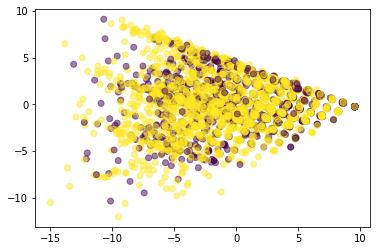

In [321]:
plotFunction(z, Y)

In [322]:
def findBestK(initial, step):
    #TODO use the getVarianceRatio to find the best K
    ratio = np.inf
    while ratio > 0.001:
        initial += step
        z = getKComponents(U, X, initial)
        ratio = getVarianceRatio(z, U, X, initial)
    return initial

In [324]:
step = 10
initial = 1
optimalK = findBestK(initial, step)
optimalK

1381

In [325]:
z = getKComponents(U, X, optimalK)

In [326]:
from sklearn.manifold import TSNE
tsne_pca_results = TSNE(n_components=2, learning_rate="auto", init="random").fit_transform(z)

In [327]:
tsne_pca_results

array([[  0.15443861, -16.106375  ],
       [-33.3408    ,  -0.69254696],
       [ -7.9689107 ,  -5.0491447 ],
       ...,
       [-10.5165825 ,   3.0175517 ],
       [ 15.534019  ,   4.629565  ],
       [-16.02449   ,  -2.199754  ]], dtype=float32)

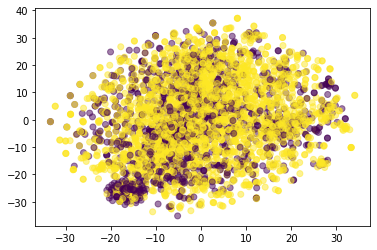

In [328]:
plotFunction(tsne_pca_results, Y)